# Back to Convolutional Autoencoder

### Initial imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Input, Conv2D, Flatten, UpSampling2D, Dense, ZeroPadding2D
from keras.models import Model
from keras.callbacks import EarlyStopping

### Loading images

In [2]:
# Dataset dependant parameters
data_path = "data/1ball/"
num_systems = 10000
num_balls = 3
pix = 32

X1 = []
for i in tqdm(glob(data_path + "Input/image1_*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    X1.append(im)
X1 = np.array(X1, dtype="float32") / 255

X2 = []
for i in tqdm(glob(data_path + "Input/image2_*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    X2.append(im)
X2 = np.array(X2, dtype="float32") / 255

Y = []
for i in tqdm(glob(data_path + "Output/*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    Y.append(im)
Y = np.array(Y, dtype="float32") / 255

100%|██████████| 10000/10000 [00:20<00:00, 488.71it/s]


### Temperature computation and data split

In [3]:
coordinates = np.loadtxt(data_path + 'coordinates.csv', delimiter=',')
coordinates = coordinates[:, -2*num_balls:] / 4

temperature = np.zeros((num_systems))

for i in range(num_systems):
    for j in range(num_balls):
        # Add the speed of each ball to the temperature
        temperature[i] += np.sqrt(np.sum(np.square(coordinates[i, 2*j : 2*(j+1)])))
    
    # Divide by number of balls to get the mean
    temperature[i] /= num_balls

# Concatenate both frames
X = np.concatenate((X1, X2), axis=3)
# Train-val-test split (80-10-10)
x_train, x_test, y_train, y_test, temperature_train, temperature_test = train_test_split(X, Y, temperature, test_size=0.2)
x_val, x_test, y_val, y_test, temperature_val, temperature_test = train_test_split(x_test, y_test, temperature_test, test_size=0.5)

### Model definition and training

In [4]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, (3,3), activation="relu", padding="same")(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, (3,3), activation="relu", padding="same")(x)
   return x

def downsample_block(x, n_filters):
   x = double_conv_block(x, n_filters)
   x = ZeroPadding2D(padding=(1, 1))(x)
   x = Conv2D(n_filters, (3,3), activation="relu", strides = (2,2))(x)
   return x

def upsample_block(x, n_filters):
   # upsample
   x = UpSampling2D(size=(2, 2), interpolation='nearest')(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x


# Input layer
inputs = Input(shape=(pix,pix,2))

# Encoder layer
u1 = downsample_block(inputs, 1)

# Bottleneck layer
bottleneck = double_conv_block(u1, 2)

# Decoder layer
u3 = upsample_block(bottleneck, 1)

# Output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(u3)

load_model = False

# Build or load model
if load_model:
   conv_autoencoder = keras.models.load_model("conv_autoencoder_1ball")
else:
   conv_autoencoder = Model(inputs, outputs, name="Convolutional_Autoencoder")

conv_autoencoder.summary()

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

Model: "Convolutional_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 1)         19        
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 1)         10        
                                                                 
 zero_padding2d (ZeroPadding  (None, 34, 34, 1)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 1)         10        
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 2)         20        
                                         

In [5]:
conv_autoencoder.compile(optimizer='adam', loss='mse')

conv_autoencoder.fit(x_train, y_train,
                epochs=250,
                batch_size=32,
                shuffle=True,
                validation_data=(x_val, y_val),
                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)])

Epoch 1/250
250/250 [==============================] - 10s 26ms/step - loss: 0.2200 - val_loss: 0.1931
Epoch 2/250
250/250 [==============================] - 4s 18ms/step - loss: 0.1704 - val_loss: 0.1494
Epoch 3/250
250/250 [==============================] - 4s 18ms/step - loss: 0.1320 - val_loss: 0.1162
Epoch 4/250
250/250 [==============================] - 5s 18ms/step - loss: 0.1032 - val_loss: 0.0913
Epoch 5/250
250/250 [==============================] - 9s 35ms/step - loss: 0.0817 - val_loss: 0.0728
Epoch 6/250
250/250 [==============================] - 7s 29ms/step - loss: 0.0656 - val_loss: 0.0590
Epoch 7/250
250/250 [==============================] - 5s 19ms/step - loss: 0.0535 - val_loss: 0.0485
Epoch 8/250
250/250 [==============================] - 5s 19ms/step - loss: 0.0443 - val_loss: 0.0405
Epoch 9/250
250/250 [==============================] - 5s 19ms/step - loss: 0.0373 - val_loss: 0.0343
Epoch 10/250
250/250 [==============================] - 5s 19ms/step - loss: 0.03

### Model reconstructions

We print (from left to right) the 3 frames of the sample (2 inputs and output), an auxiliar image to see of how much movement there is between the first and final frame, the reconstructed image and the 3rd frame over the reconstructed image. This last image is useful to see if the position of the balls is accurately predicted.

32/32 [==============================] - 1s 20ms/step


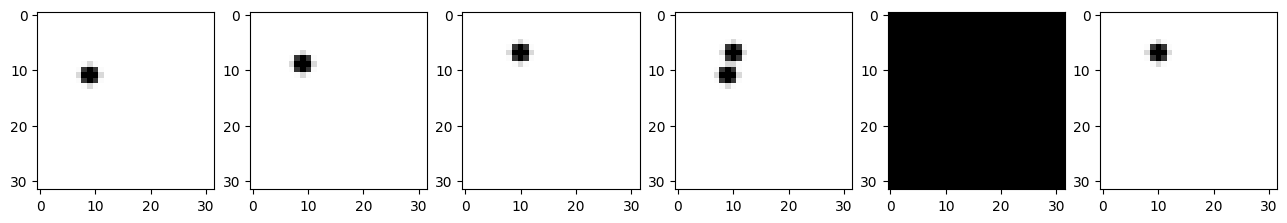

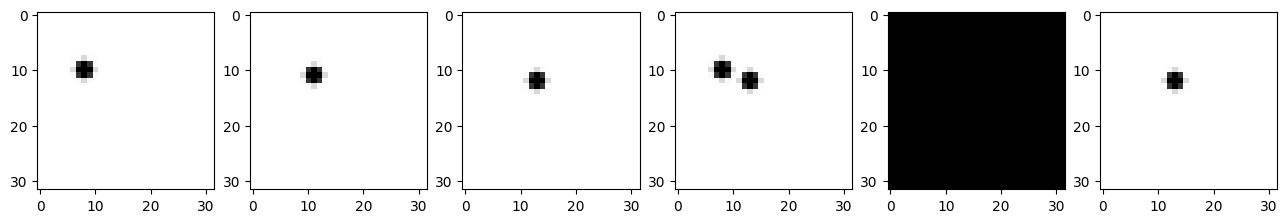

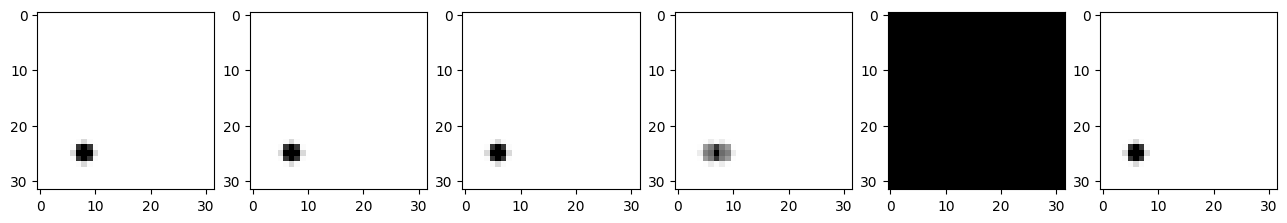

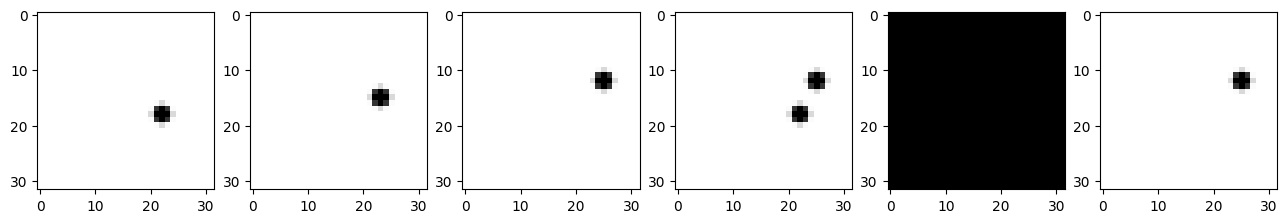

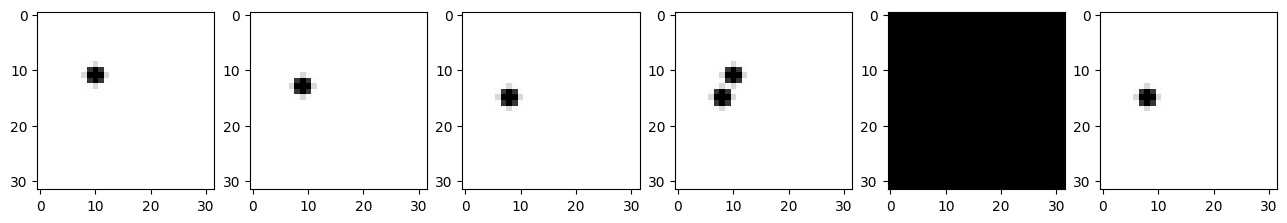

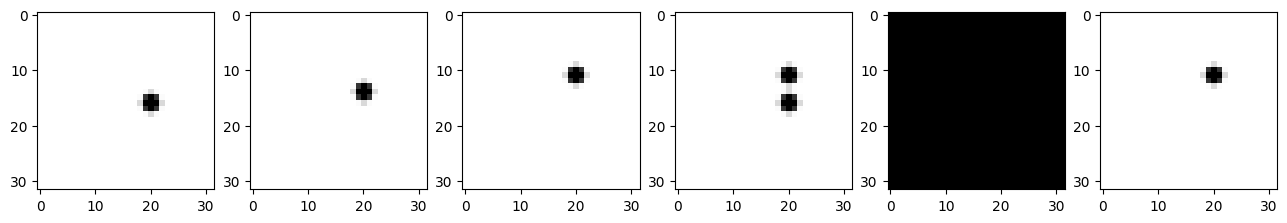

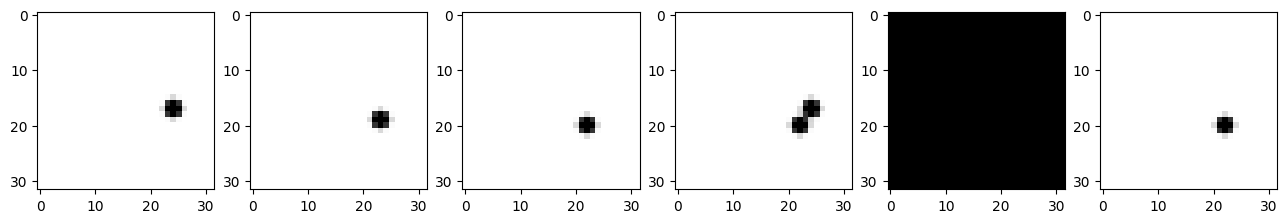

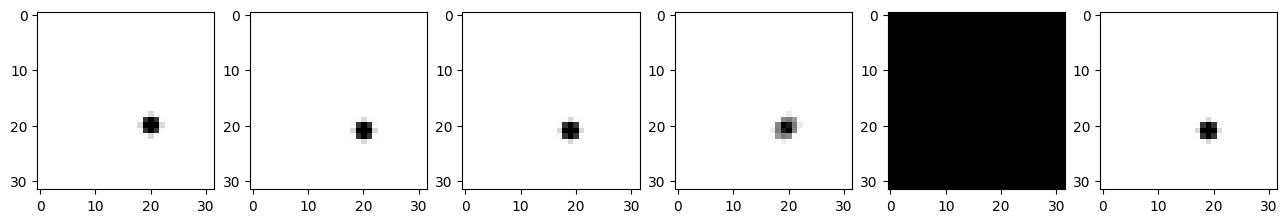

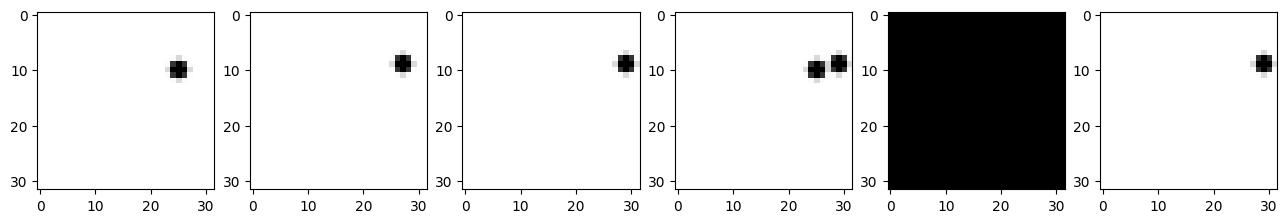

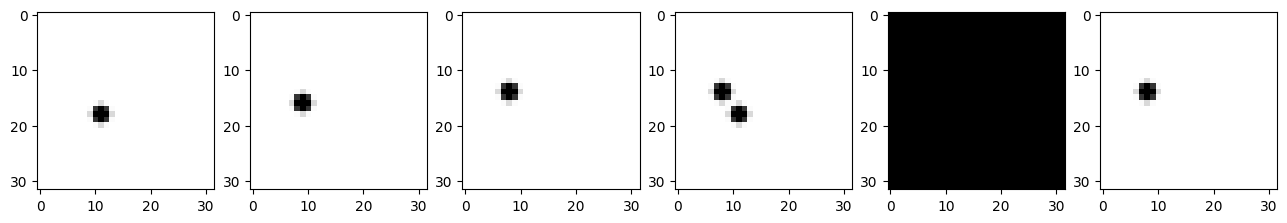

In [6]:
predictions = conv_autoencoder.predict(x_test)

for i in range(10):
    plt.figure(figsize=(16, 96))
    # First image
    plt.subplot(1, 6, 1)
    plt.imshow(x_test[i,:,:,0].reshape(pix, pix), cmap='gray')

    # Second image
    plt.subplot(1, 6, 2)
    plt.imshow(x_test[i,:,:,1].reshape(pix, pix), cmap='gray')

    # Third image
    plt.subplot(1, 6, 3)
    plt.imshow(y_test[i].reshape(pix, pix), cmap='gray')

    # Balls in first and final frame to check how much movement there is on that sample
    plt.subplot(1, 6, 4)
    plt.imshow(y_test[i].reshape(pix, pix) + x_test[i,:,:,0].reshape(pix, pix), cmap='gray')

    # Predicted image
    plt.subplot(1, 6, 5)
    plt.imshow(predictions[i].reshape(pix, pix), cmap='gray')

    # Image to predict over reconstruction
    plt.subplot(1, 6, 6)
    plt.imshow(y_test[i].reshape(pix, pix) + predictions[i].reshape(pix, pix)/2, cmap='gray')

    plt.show()

There is no point on trying to infer the temperature if the predicted images are all blank.